PROSJEKT

## Import

In [465]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 300)

# Lese inn data

In [466]:
demographic = pd.read_csv("raw_data/demographic.csv")
hospital = pd.read_csv('raw_data/hospital.csv')
physiological = pd.read_table('raw_data/physiological.txt')
severity_json = pd.read_json('raw_data/severity.json')

# Lage dummy-variabler

## Hospital

In [467]:
hospital.head()
print(hospital.dtypes)

pasient_id        int64
sykehusdød        int64
oppholdslengde    int64
dtype: object


## Demographic

In [468]:
print(demographic.dtypes)
demographic = pd.get_dummies(demographic, columns=['kjønn', 'etnisitet', 'inntekt'], dtype = int)
demographic.head()


pasient_id      int64
alder         float64
kjønn          object
utdanning     float64
inntekt        object
etnisitet      object
dtype: object


pasient_id     alder  utdanning  kjønn_female  kjønn_male  etnisitet_asian  \
0           2  60.33899       12.0             1           0                0   
1           3  52.74698       12.0             1           0                0   
2           4  42.38498       11.0             1           0                0   
3           5  79.88495        NaN             1           0                0   
4           6  93.01599       14.0             0           1                0   

   etnisitet_black  etnisitet_hispanic  etnisitet_other  etnisitet_white  \
0                0                   0                0                1   
1                0                   0                0                1   
2                0                   0                0                1   
3                0                   0                0                1   
4                0                   0                0                1   

   inntekt_$11-$25k  inntekt_$25-$50k  inntekt_>$50k  inntekt_under $11k  
0                 1                 0              0                   0  
1                 0                 0              0                   1  
2                 0                 0              0                   1  
3                 0                 0              0                   0  
4                 0                 0              0                   0

## Physiological

In [469]:
print(physiological.dtypes)
physiological.head()

pasient_id                int64
blodtrykk               float64
hvite_blodlegemer       float64
hjertefrekvens          float64
respirasjonsfrekvens    float64
kroppstemperatur        float64
lungefunksjon           float64
serumalbumin            float64
bilirubin               float64
kreatinin               float64
natrium                 float64
blod_ph                 float64
glukose                 float64
blodurea_nitrogen       float64
urinmengde              float64
dtype: object


pasient_id  blodtrykk  hvite_blodlegemer  hjertefrekvens  \
0           2       43.0          17.097656           112.0   
1           3       70.0           8.500000            88.0   
2           4       75.0           9.099609            88.0   
3           5       59.0          13.500000           112.0   
4           6      110.0          10.398438           101.0   

   respirasjonsfrekvens  kroppstemperatur  lungefunksjon  serumalbumin  \
0                  34.0          34.59375       98.00000           NaN   
1                  28.0          37.39844      231.65625           NaN   
2                  32.0          35.00000            NaN           NaN   
3                  20.0          37.89844      173.31250           NaN   
4                  44.0          38.39844      266.62500           NaN   

   bilirubin  kreatinin  natrium   blod_ph  glukose  blodurea_nitrogen  \
0        NaN   5.500000    132.0  7.250000      NaN                NaN   
1   2.199707   2.000000    134.0  7.459961      NaN                NaN   
2        NaN   0.799927    139.0       NaN      NaN                NaN   
3        NaN   0.799927    143.0  7.509766      NaN                NaN   
4        NaN   0.699951    140.0  7.659180      NaN                NaN   

   urinmengde  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

## Severity

In [470]:
#Bruker index -1 fordi velger å ikke ta med siste kolonne, fordi tenker den ikke er nødvendig å ha med. 
severity = severity_json.iloc[:,0:-1].explode(list(severity_json.columns[2:-1]))
severity.reset_index(drop=True, inplace=True)
severity = severity.sort_values(by=['pasient_id'], ignore_index=True)
#severity_df

#fjerner to kolonner som forteller om sykdomskategori, fordi det blir dobbelt opp med informasjon. 
# Fordi underkategorien forteller oss hvilken kategori sykdommen tilhører. 
severity = severity.drop(columns=['sykdomskategori_id', 'sykdomskategori'])

#gjør object kolonner til numeriske
severity = pd.get_dummies(severity, columns=['sykdom_underkategori','kreft', 'dnr_status'], dtype = int)

severity.head(10)


pasient_id dødsfall antall_komorbiditeter koma_score adl_pasient  \
0          2        1                     2       44.0        None   
1          3        1                     2        0.0         1.0   
2          4        1                     2        0.0         0.0   
3          5        0                     1       26.0        None   
4          6        1                     1       55.0        None   
5          7        1                     1        0.0         0.0   
6          8        1                     3       26.0        None   
7          9        1                     2       26.0        None   
8         10        1                     0        0.0         0.0   
9         11        1                     1        0.0         2.0   

  adl_stedfortreder fysiologisk_score apache_fysiologisk_score  \
0               1.0         52.695312                     74.0   
1               0.0              20.5                     45.0   
2               0.0         20.097656                     19.0   
3               2.0              23.5                     30.0   
4               1.0         19.398438                     27.0   
5               1.0         17.296875                     46.0   
6               0.0         21.597656                     53.0   
7               7.0         15.898438                     17.0   
8              None          2.299805                      9.0   
9               1.0         14.599609                     14.0   

  overlevelsesestimat_2mnd overlevelsesestimat_6mnd diabetes demens  \
0                    0.001                      0.0        0      0   
1                 0.790894                 0.664917        0      0   
2                 0.698975                 0.411987        0      0   
3                 0.634888                 0.532959        0      0   
4                 0.284973                 0.214996        0      0   
5                 0.892944                 0.820923        0      0   
6                 0.670898                 0.498962        1      0   
7                 0.570923                 0.248993        0      1   
8                 0.952881                 0.887939        0      0   
9                 0.935913                 0.890991        0      0   

  lege_overlevelsesestimat_2mnd lege_overlevelsesestimat_6mnd  \
0                           0.0                           0.0   
1                          0.75                           0.5   
2                           0.9                           0.5   
3                           0.9                           0.9   
4                           0.0                           0.0   
5                          None                           0.7   
6                           0.8                           0.4   
7                          0.05                      0.000125   
8                          None                          None   
9                           0.7                           0.5   

   sykdom_underkategori_ARF/MOSF w/Sepsis  sykdom_underkategori_CHF  \
0                                       0                         0   
1                                       0                         0   
2                                       0                         0   
3                                       1                         0   
4                                       0                         0   
5                                       0                         1   
6                                       0                         1   
7                                       0                         0   
8                                       0                         0   
9                                       0                         1   

   sykdom_underkategori_COPD  sykdom_underkategori_Cirrhosis  \
0                          0                               1   
1                          0                               1   
2                          0    

# Merge data


In [471]:
#Merger alle dataframes til en stor dataframe

merged_table = pd.merge(hospital, physiological, on='pasient_id', how='outer')
merged_table = pd.merge(merged_table, demographic, on='pasient_id', how='outer')
merged_table = pd.merge(merged_table, severity, on='pasient_id', how='outer')

merged_table

pasient_id  sykehusdød  oppholdslengde  blodtrykk  hvite_blodlegemer  \
0             2           1               4       43.0          17.097656   
1             3           0              17       70.0           8.500000   
2             4           0               3       75.0           9.099609   
3             4           0               3       75.0           9.099609   
4             5           0             -99       59.0          13.500000   
...         ...         ...             ...        ...                ...   
7737       9101           0              23      109.0           7.399414   
7738       9102           0              29       43.0                NaN   
7739       9103           0               8      111.0           8.398438   
7740       9104           1               7       99.0           7.599609   
7741       9105           0              12       75.0           8.599609   

      hjertefrekvens  respirasjonsfrekvens  kroppstemperatur  lungefunksjon  \
0              112.0                  34.0          34.59375       98.00000   
1               88.0                  28.0          37.39844      231.65625   
2               88.0                  32.0          35.00000            NaN   
3               88.0                  32.0          35.00000            NaN   
4              112.0                  20.0          37.89844      173.31250   
...              ...                   ...               ...            ...   
7737           104.0                  22.0          35.69531      280.00000   
7738             0.0                   8.0          38.59375      218.50000   
7739            83.0                  24.0          36.69531      180.00000   
7740           110.0                  24.0          36.39844      428.56250   
7741            69.0                  24.0          36.19531      230.40625   

      serumalbumin  bilirubin  kreatinin  natrium   blod_ph  glukose  \
0              NaN        NaN   5.500000    132.0  7.250000      NaN   
1              NaN   2.199707   2.000000    134.0  7.459961      NaN   
2              NaN        NaN   0.799927    139.0       NaN      NaN   
3              NaN        NaN   0.799927    139.0       NaN      NaN   
4              NaN        NaN   0.799927    143.0  7.509766      NaN   
...            ...        ...        ...      ...       ...      ...   
7737      3.699707   0.399963   1.099854    131.0  7.459961    188.0   
7738           NaN        NaN   5.899414    135.0  7.289062    190.0   
7739           NaN   0.399963   2.699707    139.0  7.379883    189.0   
7740      1.199951   0.399963   3.500000    135.0  7.469727    246.0   
7741      4.500000   0.599976   1.199951    137.0  7.289062    187.0   

      blodurea_nitrogen  urinmengde     alder  utdanning  kjønn_female  \
0                   NaN         NaN  60.33899       12.0             1   
1                   NaN         NaN  52.74698       12.0             1   
2                   NaN         NaN  42.38498       11.0             1   
3                   NaN         NaN  42.38498       11.0             1   
4                   NaN         NaN  79.88495        NaN             1   
...                 ...         ...       ...        ...           ...   
7737               21.0         NaN  66.07300        8.0             0   
7738               49.0         0.0  55.15399       11.0             1   
7739               60.0      3900.0  70.38196        NaN             0   
7740               55.0         NaN  47.01999       13.0             0   
7741               15.0         NaN  81.53894        8.0             1   

      kjønn_male  etnisitet_asian  etnisitet_black  etnisitet_hispanic  \
0              0                0                0                   0   
1              0                0                0                   0   
2              0                0                0                   0   
3              0                0                0                   0   
4      

## Duplikater


Har fjernet 2 duplikater. 

In [472]:
#fjerne duplikater, med samme pasient_id
merged_table = merged_table.drop_duplicates(subset=['pasient_id'])

#sjekke hvor mange unike pasient_id det finnes
unik_id = merged_table['pasient_id'].nunique()
print(unik_id)

7740


## Kartlegge negative verdier

Ser at det er alder og oppholdslengde som har negative verdier. 

Det er 11 pasienter med negtiv opphold og alder tilsammen. 

In [473]:
#sjekker hvilke kolonner som inneholder negative verdier, og hvor mange. 

numeriske_kolonner = merged_table.select_dtypes(include=[np.number])
negative_values = (numeriske_kolonner < 0)
kolonner_med_negative_verdier = negative_values.any()
kolonner_med_negativ = kolonner_med_negative_verdier[kolonner_med_negative_verdier].index.tolist()
antall_negative_per_kolonne = negative_values.sum()
antall_negative_per_kolonne = antall_negative_per_kolonne[antall_negative_per_kolonne > 0]


print("Negative verdier:\n", antall_negative_per_kolonne)



Antall negative verdier:
 oppholdslengde    6
alder             5
dtype: int64


## Fjerne pasienter med negativ oppholdslengde og alder
Siden det bare er 5 pasienter med negativ alder og 6 stk med negativ oppholdslengde så fjerner jeg disse. Tenker at det går fint siden 11 stykker av over 7000 pasienter ikke utgjør så mye forskjell for modellen. 

In [474]:
#fjerne pasienter med negativ oppholdslengde fordi de vil ødelegge modellen?
merged_table = merged_table[merged_table['oppholdslengde'] >= 0]

# Fjerner alle pasienter med negativ alders
merged_table = merged_table[merged_table['alder'] >= 0]

print(merged_table.shape)

merged_table = merged_table.replace({None: np.nan})

(7729, 56)


/var/folders/3p/1s5nsl_n0qd2lhfhfxkkwc6m0000gn/T/ipykernel_57691/1672647992.py:9: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



## Fyll ut gitte verdier fra nettside

Gjør dette før jeg deler opp for å gjøre det enklere. Det går fint siden det er bestemte tall, og ikke tall som er bestemt ut fra treningsdata. 


In [475]:
# Hvite blodlegemer: Fyll ut med 9000 for de som mangler verdi (NaN)
merged_table.loc[:, 'hvite_blodlegemer'] = merged_table['hvite_blodlegemer'].fillna(9)

# Serumalbumin: Fyll ut med 3.5
merged_table.loc[:, 'serumalbumin'] = merged_table['serumalbumin'].fillna(3.5)

# Kreatinin: Fyll ut med 1.01
merged_table.loc[:, 'kreatinin'] = merged_table['kreatinin'].fillna(1.01)

# Urinmengde: Fyll ut med 2502
merged_table.loc[:, 'urinmengde'] = merged_table['urinmengde'].fillna(2502)

#bilirubin: Fyll ut med 1.01
merged_table.loc[:, 'bilirubin'] = merged_table['bilirubin'].fillna(1.01)

#lungefunkjson: Fyller ut med 333.3
merged_table.loc[:, 'lungefunksjon'] = merged_table['lungefunksjon'].fillna(333.3)

#blodure_nitrogen, BUN . Fyller ut med 6.51
merged_table.loc[:, 'blodurea_nitrogen'] = merged_table['blodurea_nitrogen'].fillna(6.51)


# Dele opp lungefunksjon

- Mild: 200-300
- Moderate: 100-200
- Severve: < 100

In [476]:
bins = [-np.inf, 100, 200, 300, np.inf]
labels = ['Severe', 'Moderate', 'Mild', 'Over 300']
merged_table['lungefunksjon_kategori'] = pd.cut(merged_table['lungefunksjon'], bins=bins, labels=labels)

merged_table= pd.get_dummies(merged_table, columns=['lungefunksjon_kategori'], dtype=int)
merged_table

pasient_id  sykehusdød  oppholdslengde  blodtrykk  hvite_blodlegemer  \
0              2           1               4       43.0          17.097656   
1              3           0              17       70.0           8.500000   
2              4           0               3       75.0           9.099609   
5              6           1               4      110.0          10.398438   
6              7           0               9       78.0          11.699219   
...          ...         ...             ...        ...                ...   
7737        9101           0              23      109.0           7.399414   
7738        9102           0              29       43.0           9.000000   
7739        9103           0               8      111.0           8.398438   
7740        9104           1               7       99.0           7.599609   
7741        9105           0              12       75.0           8.599609   

      hjertefrekvens  respirasjonsfrekvens  kroppstemperatur  lungefunksjon  \
0              112.0                  34.0          34.59375       98.00000   
1               88.0                  28.0          37.39844      231.65625   
2               88.0                  32.0          35.00000      333.30000   
5              101.0                  44.0          38.39844      266.62500   
6              120.0                  28.0          37.39844      309.50000   
...              ...                   ...               ...            ...   
7737           104.0                  22.0          35.69531      280.00000   
7738             0.0                   8.0          38.59375      218.50000   
7739            83.0                  24.0          36.69531      180.00000   
7740           110.0                  24.0          36.39844      428.56250   
7741            69.0                  24.0          36.19531      230.40625   

      serumalbumin  bilirubin  kreatinin  natrium   blod_ph  glukose  \
0         3.500000   1.010000   5.500000    132.0  7.250000      NaN   
1         3.500000   2.199707   2.000000    134.0  7.459961      NaN   
2         3.500000   1.010000   0.799927    139.0       NaN      NaN   
5         3.500000   1.010000   0.699951    140.0  7.659180      NaN   
6         4.799805   0.399963   1.599854    132.0  7.479492      NaN   
...            ...        ...        ...      ...       ...      ...   
7737      3.699707   0.399963   1.099854    131.0  7.459961    188.0   
7738      3.500000   1.010000   5.899414    135.0  7.289062    190.0   
7739      3.500000   0.399963   2.699707    139.0  7.379883    189.0   
7740      1.199951   0.399963   3.500000    135.0  7.469727    246.0   
7741      4.500000   0.599976   1.199951    137.0  7.289062    187.0   

      blodurea_nitrogen  urinmengde     alder  utdanning  kjønn_female  \
0                  6.51      2502.0  60.33899       12.0             1   
1                  6.51      2502.0  52.74698       12.0             1   
2                  6.51      2502.0  42.38498       11.0             1   
5                  6.51      2502.0  93.01599       14.0             0   
6                  6.51      2502.0  62.37097       14.0             0   
...                 ...         ...       ...        ...           ...   
7737              21.00      2502.0  66.07300        8.0             0   
7738              49.00         0.0  55.15399       11.0             1   
7739              60.00      3900.0  70.38196        NaN             0   
7740              55.00      2502.0  47.01999       13.0             0   
7741              15.00      2502.0  81.53894        8.0             1   

      kjønn_male  etnisitet_asian  etnisitet_black  etnisitet_hispanic  \
0              0                0                0                   0   
1              0                0                0                   0   
2              0                0                0                   0   
5              1                0                0                   0

# Dele opp i 3 datasett


In [478]:
#Dele opp i trening, validering og testdata

# del data i mål-, og prediktorvariabl
X = merged_table.drop('oppholdslengde', axis=1)  # Alle kolonner unntatt 'oppholdslengde'
y = merged_table['oppholdslengde']  # Målvariabel = 'oppholdslengde'


#dele data inn i 70/30
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)


#printer størrelse på de ulike datasettene
print(f"Treningsdata: {X_train.shape}")
print(f"Valideringsdata: {X_val.shape}")
print(f"Testdata: {X_test.shape}")


Treningsdata: (5410, 59)
Valideringsdata: (1159, 59)
Testdata: (1160, 59)


# Lage en train dataframe. 

In [479]:
# Lager en dataframe av treningsdata
train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

# Dataforståelse

## Describe

In [480]:
beskrivelse = train_df.describe()
print(beskrivelse)

        pasient_id   sykehusdød    blodtrykk  hvite_blodlegemer  \
count  5410.000000  5410.000000  5410.000000        5410.000000   
mean   4570.926433     0.261368    84.693438          12.340621   
std    2623.926935     0.439421    27.808522           9.384883   
min       3.000000     0.000000     0.000000           0.000000   
25%    2321.750000     0.000000    64.000000           7.000000   
50%    4555.500000     0.000000    77.000000          10.398438   
75%    6843.250000     1.000000   108.000000          15.174316   
max    9105.000000     1.000000   193.000000         117.000000   

       hjertefrekvens  respirasjonsfrekvens  kroppstemperatur  lungefunksjon  \
count     5410.000000           5410.000000       5410.000000    5410.000000   
mean        97.618983             23.406654         37.138702     263.188839   
std         31.305589              9.554365          1.266966     104.322160   
min          0.000000              0.000000         31.699220      12.000000

## Verdier målt på dag 7 og None verdier

Litt usikker på hva jeg skal gjøre med disse.

In [481]:
# Erstatt de som mangler verdier i kolonnene 'bilirubin' og 'adl_pasient' med NaN 
# fordi de som ikke er innlagt lengre enn 7 dager blir ikke målt på disse pga de måles på dag 7
#X_train.loc[:, 'bilirubin'] = X_train['bilirubin'].replace({None: np.nan})
#X_train.loc[:, 'adl_pasient'] = X_train['adl_pasient'].replace({None: np.nan})



# Visualiseringer på train

## Korrelasjon

In [482]:
#lage korrelasjonsmatrise for å se forhold mellom 

corr_matrix = train_df.corr()

#lager et heat map for å visualisere korrelasjonsmatrisen
fig = px.imshow(corr_matrix,
                labels = dict (x = 'x', y = 'y', color = 'Correlation'),
                x = corr_matrix.columns,
                y = corr_matrix.columns,
                color_continuous_scale='RdBu_r',
                aspect = 'auto')

fig.update_layout(
    yaxis = dict (tickmode = 'linear',
                  tick0 = 0,
                  dtick = 1
                 ),
    xaxis = dict (tickmode = 'linear',
                  tick0 = 0,
                  dtick = 1
                 ),
            autosize = False,
            height = 1000,
            width = 1000)

fig.show()


## Scatter plot med oppholdslengde

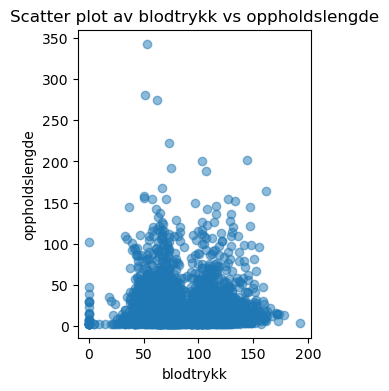

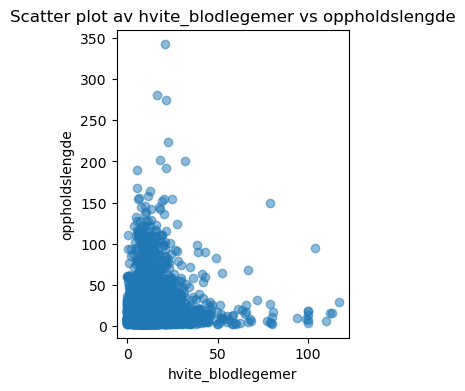

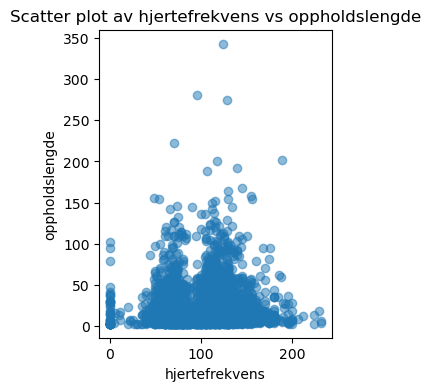

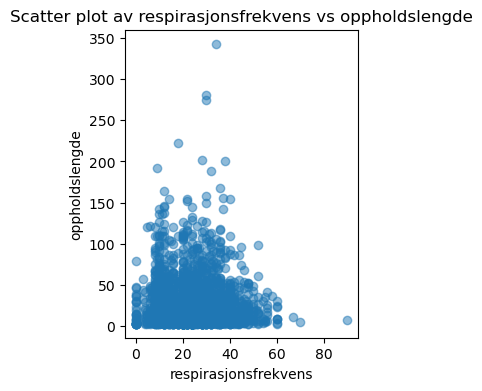

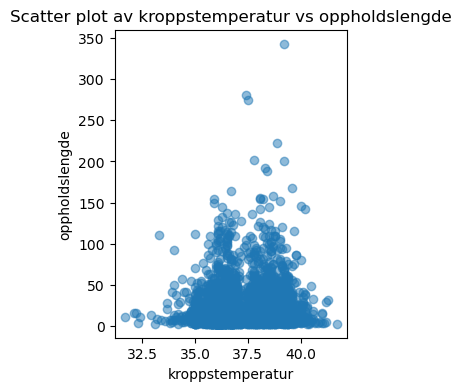

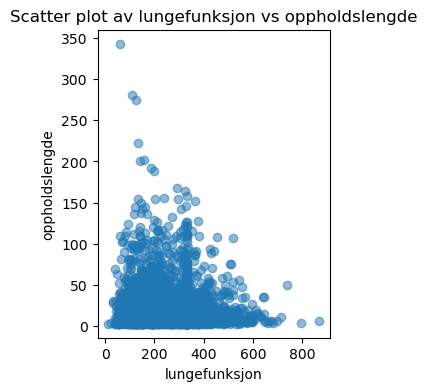

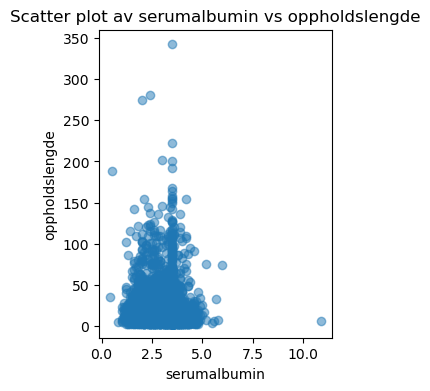

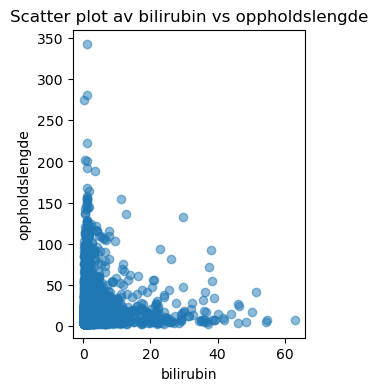

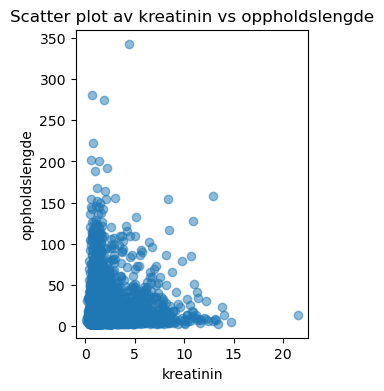

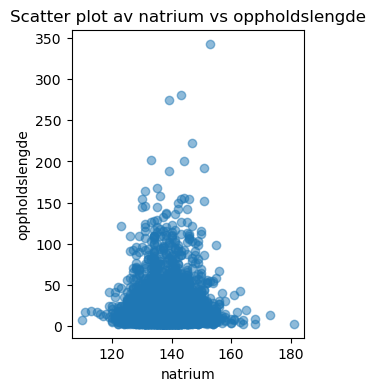

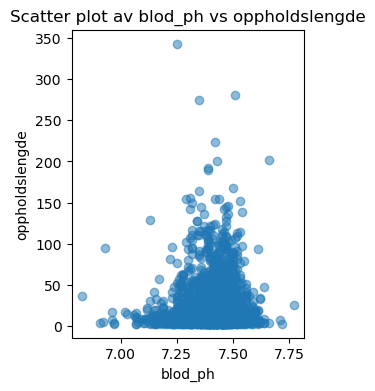

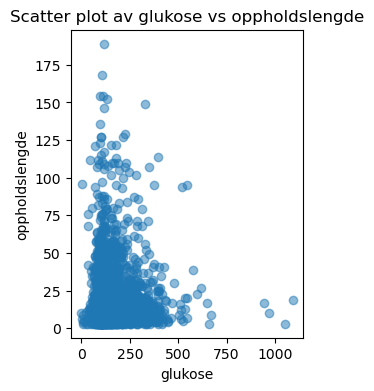

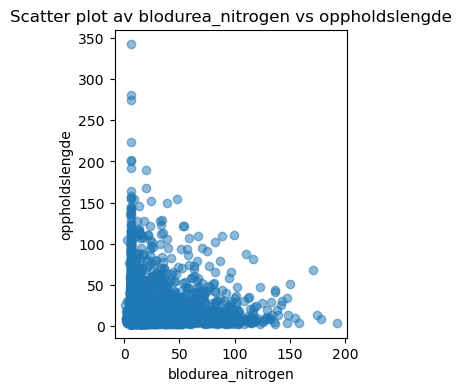

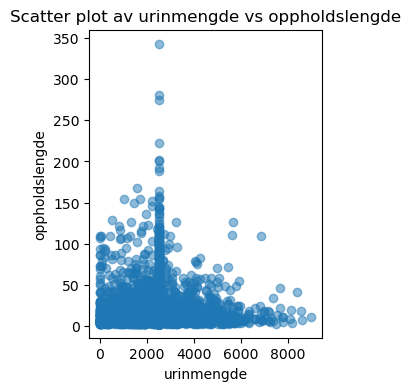

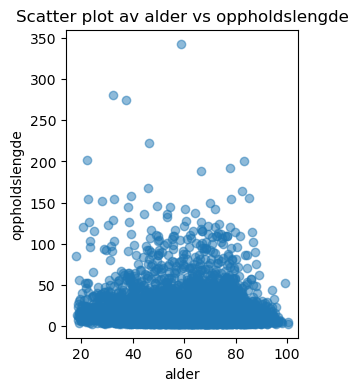

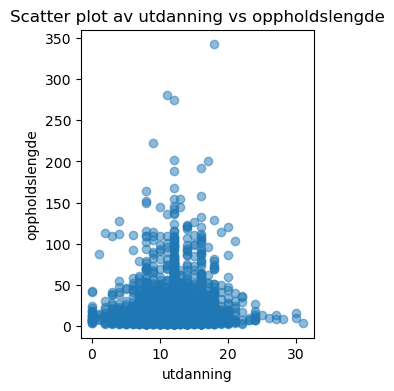

In [483]:
numeriske_variabler = [
     'blodtrykk', 'hvite_blodlegemer', 'hjertefrekvens',
    'respirasjonsfrekvens', 'kroppstemperatur', 'lungefunksjon', 'serumalbumin', 
    'bilirubin', 'kreatinin', 'natrium', 'blod_ph', 'glukose', 'blodurea_nitrogen', 
    'urinmengde', 'alder', 'utdanning'
]


for var in numeriske_variabler:
    plt.figure(figsize=(3,4))
    plt.scatter(train_df[var], train_df['oppholdslengde'], alpha=0.5)
    
    # tittel på aksene
    plt.title(f'Scatter plot av {var} vs oppholdslengde')
    plt.xlabel(var)
    plt.ylabel('oppholdslengde')
    plt.show()


## Box plot av kjønn og oppholdslengde

In [484]:
fig = px.box(train_df, x='kjønn_male', y='oppholdslengde',
             labels={'kjønn_male': 'Kjønn (0 = Female, 1 = Male)', 'oppholdslengde': 'Oppholdslengde'},
             title='Oppholdslengde basert på kjønn')
fig.show()


## Box plot av sykdommer og oppholdslengde

In [485]:
disease_cols = {
    'demens', 'diabetes', 'kreft_metastatic', 'kreft_yes', 
    'sykdom_underkategori_ARF/MOSF w/Sepsis', 'sykdom_underkategori_CHF',
    'sykdom_underkategori_COPD', 'sykdom_underkategori_Cirrhosis', 
    'sykdom_underkategori_Colon Cancer', 'sykdom_underkategori_Coma', 
    'sykdom_underkategori_Lung Cancer', 'sykdom_underkategori_MOSF w/Malig'
}


disease_melted = pd.melt(
    train_df,  
    id_vars=['oppholdslengde'],
    value_vars=disease_cols,
    var_name='Sykdom',
    value_name='Har sykdom'
)

disease_melted = disease_melted[disease_melted['Har sykdom'] == 1]  

fig = px.box(
    disease_melted,
    x='Sykdom',
    y='oppholdslengde',
    color='Sykdom',
    title='Oppholdslengde i forhold til sykdomskategori',
    labels={'oppholdslengde': 'Oppholdslengde', 'Sykdom': 'Sykdom'},
    width=1300,
    height=1000
)


fig.update_layout(xaxis={'categoryorder': 'total descending'})


fig.show()

## Kartlegge manglende verdier

In [486]:
manglende_verdier = X_train.isnull().sum()
print('Manglende verdier:')
print(manglende_verdier[manglende_verdier > 0])

Manglende verdier:
blod_ph                          1330
glukose                          2667
utdanning                         977
adl_pasient                      3375
adl_stedfortreder                1702
lege_overlevelsesestimat_2mnd    1006
lege_overlevelsesestimat_6mnd     994
dtype: int64


## Manglende verdier




https://archive.ics.uci.edu/dataset/880/support2

  

## Slå sammen ADL 

In [22]:
#gjør dette senere, må sjekke om det har positiv effekt for modellene

# Baseline, enkel grunnlinjemodell


In [493]:

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)
pred = baseline.predict(X_val)
rmse_baseline = np.sqrt(mean_squared_error(y_val, pred))
print(f"Baseline: {rmse_baseline}")


Baseline: 18.683613878347693


# Imputasjon: midlertidig

#simpleImputor
#KnnImputor
  

In [488]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler


#midlertidig imputasjon med median
#imputer = SimpleImputer(strategy='mean')

# Bruk fit_transform for å erstatte NaN-verdier med gjennomsnittet for hver kolonne
#X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
#X_val = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)


## Standardisering av data (mellom 0 og 1) Er dette nødvendig?

In [489]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# PCA testing. Usikker på om dette er nødvendig

In [490]:
# Utfør PCA og behold komponenter som forklarer 95 % av variansen
#pca = PCA(n_components=0.95)
#X_pca = pca.fit_transform(X_scaled)

#print(f"Antall komponenter valgt: {pca.n_components_}")

#print(f"Forklart varians av hver komponent: {pca.explained_variance_ratio_}")



# Teste modeller

In [491]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


models = {
    'kNN-1': KNeighborsClassifier(n_neighbors=1),
    'kNN-10': KNeighborsClassifier(n_neighbors=10),
    'kNN-50': KNeighborsClassifier(n_neighbors=50),
    'Naive Bayes': GaussianNB(),
    'Tilfeldig Skog': RandomForestClassifier(random_state=42),
}

imputation_methods = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'most_frequent': SimpleImputer(strategy='most_frequent'),
    'constant_0': SimpleImputer(strategy='constant', fill_value=0),
    'knn': KNNImputer(n_neighbors=5)
}


results = []

for imputer_name, imputer in imputation_methods.items():
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.fit_transform(X_test)
    for model_name, model in models.items():
        model.fit(X_train_imputed, y_train)
        y_pred = model.predict(X_test_imputed)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results.append((imputer_name, model_name, rmse))
        print(f"Imputasjon: {imputer_name} modell: {model_name}")
        print(f"RMSE: {rmse:.4f}\n")



# Resultater som viser hvilken imputasjonsmetode og modellkombinasjon som er best
results_df = pd.DataFrame(results, columns=['Imputation Method', 'Model', 'RMSE'])
best_result = results_df.loc[results_df['RMSE'].idxmin()]

print("Beste kombinasjon:")
print(f"Imputasjonsmetode: {best_result['Imputation Method']}, Modell: {best_result['Model']}, RMSE: {best_result['RMSE']:.4f}")





Imputasjon: mean modell: kNN-1
RMSE: 33.0340

Imputasjon: mean modell: kNN-10
RMSE: 28.0146

Imputasjon: mean modell: kNN-50
RMSE: 28.4946

Imputasjon: mean modell: Naive Bayes
RMSE: 46.3216

Imputasjon: mean modell: Tilfeldig Skog
RMSE: 26.6060

Imputasjon: median modell: kNN-1
RMSE: 33.1731

Imputasjon: median modell: kNN-10
RMSE: 28.0107

Imputasjon: median modell: kNN-50
RMSE: 28.4844

Imputasjon: median modell: Naive Bayes
RMSE: 46.5808

Imputasjon: median modell: Tilfeldig Skog
RMSE: 26.8477

Imputasjon: most_frequent modell: kNN-1
RMSE: 33.2204

Imputasjon: most_frequent modell: kNN-10
RMSE: 27.9985

Imputasjon: most_frequent modell: kNN-50
RMSE: 28.4906

Imputasjon: most_frequent modell: Naive Bayes
RMSE: 46.6785

Imputasjon: most_frequent modell: Tilfeldig Skog
RMSE: 26.7664

Imputasjon: constant_0 modell: kNN-1
RMSE: 32.7877

Imputasjon: constant_0 modell: kNN-10
RMSE: 27.9524

Imputasjon: constant_0 modell: kNN-50
RMSE: 28.4826

Imputasjon: constant_0 modell: Naive Bayes
RMS